# Analytical Bistable Beam Force-Displacement Model

Energy minimization approach based on:
- Qiu, Lang & Slocum, "A Centrally-Clamped Parallel-Beam Bistable MEMS Mechanism" (JMEMS 2004)
- Baker, "How the cricket chirps" (PNAS 2003) for CCS extension

The beam deflection is expanded in symmetric buckling modes:
$$w(x) = \sum a_n \phi_n(x), \quad \phi_n(x) = \frac{1}{2}[1 - \cos(2n\pi x/L)], \quad n = 1, 3, 5$$

For each prescribed center displacement $\delta$, minimize total energy (bending + axial)
over free mode amplitudes. Force is obtained by differentiating the minimized energy.

In [1]:
import sys
import os
import numpy as np
from scipy.optimize import minimize_scalar, minimize
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS,
    get_beam_centerline, get_beam_width_profile,
    get_moment_of_inertia_profile,
)

# Beam parameters
L = DEFAULT_BEAM_PARAMS["span"]           # 40 µm
h = DEFAULT_BEAM_PARAMS["initial_offset"]  # 1.2 µm
t = POLY_SI["t"]                           # 0.5 µm
E = POLY_SI["E"]                           # 160,000 MPa
nu = POLY_SI["nu"]                         # 0.22

Q = h / t
print(f"Bistability ratio Q = h/t = {Q:.2f} (need > 2.31 for bistability)")
print(f"Beam: L={L} µm, h={h} µm, t={t} µm, E={E/1e3:.0f} GPa")

Bistability ratio Q = h/t = 2.40 (need > 2.31 for bistability)
Beam: L=40.0 µm, h=1.2 µm, t=0.5 µm, E=160 GPa


## 1. Beam Geometry Visualization

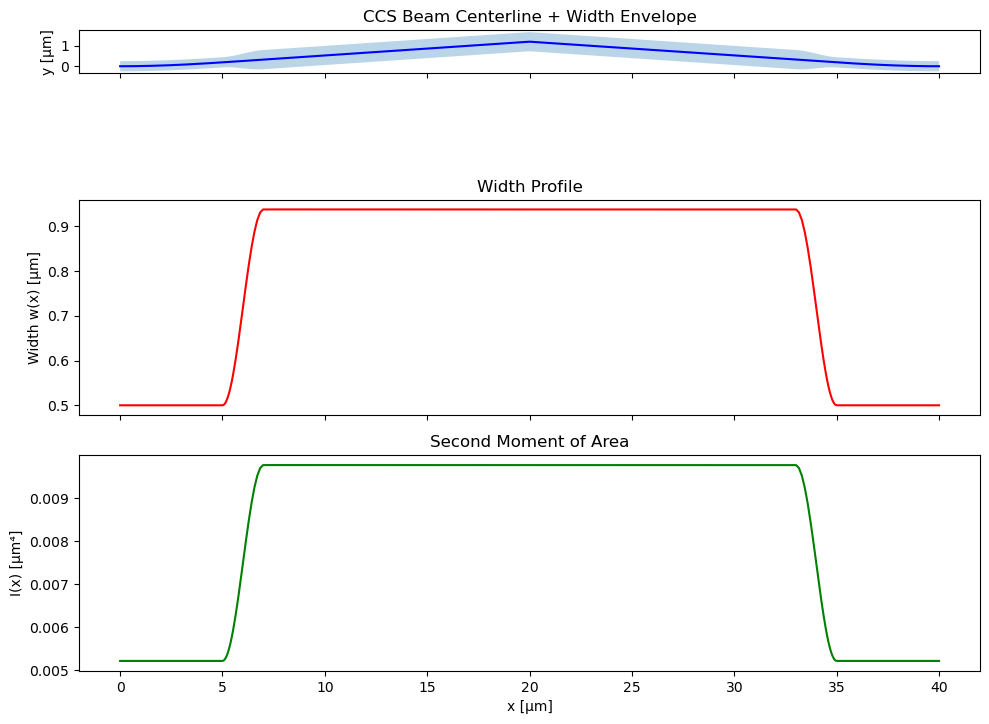

In [2]:
x_cl, y_cl = get_beam_centerline()
w_prof = get_beam_width_profile(x_cl)
I_prof = get_moment_of_inertia_profile(x_cl)

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(x_cl, y_cl, 'b-', linewidth=1.5)
axes[0].fill_between(x_cl, y_cl - w_prof/2, y_cl + w_prof/2, alpha=0.3)
axes[0].set_ylabel('y [µm]')
axes[0].set_title('CCS Beam Centerline + Width Envelope')
axes[0].set_aspect('equal')

axes[1].plot(x_cl, w_prof, 'r-', linewidth=1.5)
axes[1].set_ylabel('Width w(x) [µm]')
axes[1].set_title('Width Profile')

axes[2].plot(x_cl, I_prof, 'g-', linewidth=1.5)
axes[2].set_ylabel('I(x) [µm⁴]')
axes[2].set_xlabel('x [µm]')
axes[2].set_title('Second Moment of Area')

fig.tight_layout()
fig.savefig('plots/analytical_beam_geometry.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Mode Shape Functions

Symmetric buckling modes for a clamped-clamped beam:
$$\phi_n(x) = \frac{1}{2}\left[1 - \cos\left(\frac{2n\pi x}{L}\right)\right], \quad n = 1, 3, 5$$

Properties:
- $\phi_n(0) = \phi_n(L) = 0$ (clamped ends)
- $\phi_n(L/2) = 1$ for odd $n$ (center displacement)
- $\phi_n'(0) = \phi_n'(L) = 0$ (zero slope at clamps)

In [3]:
def phi(n, x, L):
    """Mode shape function."""
    return 0.5 * (1.0 - np.cos(2.0 * n * np.pi * x / L))

def phi_xx(n, x, L):
    """Second derivative of mode shape (curvature)."""
    return 2.0 * (n * np.pi / L)**2 * np.cos(2.0 * n * np.pi * x / L)

def phi_x(n, x, L):
    """First derivative of mode shape (slope)."""
    return (n * np.pi / L) * np.sin(2.0 * n * np.pi * x / L)

# Verify modes at center
x_fine = np.linspace(0, L, 1000)
for n in [1, 3, 5]:
    print(f"phi_{n}(L/2) = {phi(n, L/2, L):.3f}, "
          f"phi_{n}'(0) = {phi_x(n, 0, L):.6f}, "
          f"phi_{n}'(L) = {phi_x(n, L, L):.6f}")

phi_1(L/2) = 1.000, phi_1'(0) = 0.000000, phi_1'(L) = -0.000000
phi_3(L/2) = 1.000, phi_3'(0) = 0.000000, phi_3'(L) = -0.000000
phi_5(L/2) = 1.000, phi_5'(0) = 0.000000, phi_5'(L) = -0.000000


## 3. Uniform Cosine Beam (Literature Validation)

For a uniform beam (constant $I$):
- Bending energy: $U_{\text{bend}} = \frac{2\pi^4 EI}{L^3} \sum n^4 a_n^2$
- Axial shortening: $S = \frac{\pi^2}{2L} \sum n^2 a_n^2$, initial $S_0 = \frac{\pi^2 h^2}{2L}$
- Axial energy: $U_{\text{axial}} = \frac{1}{2} \frac{EA}{L} (S - S_0)^2$
  where $A = w \cdot t$ is cross-section area

In [4]:
# Uniform beam properties (use flex_width as representative)
w_uniform = DEFAULT_BEAM_PARAMS["flex_width"]  # 0.5 µm
I_uniform = w_uniform * t**3 / 12.0
A_uniform = w_uniform * t

print(f"Uniform beam: w={w_uniform} µm, I={I_uniform:.6f} µm⁴, A={A_uniform:.4f} µm²")

modes = [1, 3, 5]

def energy_uniform(a_coeffs, delta, E, I, A, L, h):
    """Total energy for uniform beam given mode amplitudes.
    
    a_coeffs: [a1, a3, a5] mode amplitudes
    delta: prescribed center displacement (a1 + a3 + a5 = delta)
    """
    # Bending energy
    U_bend = 0.0
    for n, a in zip(modes, a_coeffs):
        U_bend += n**4 * a**2
    U_bend *= 2.0 * np.pi**4 * E * I / L**3
    
    # Axial shortening
    S = 0.0
    for n, a in zip(modes, a_coeffs):
        S += n**2 * a**2
    S *= np.pi**2 / (2.0 * L)
    
    S0 = np.pi**2 * h**2 / (2.0 * L)
    
    # Axial energy
    U_axial = 0.5 * E * A / L * (S - S0)**2
    
    return U_bend + U_axial


def minimize_energy_uniform(delta, E, I, A, L, h):
    """Minimize energy over free modes (a3, a5) with constraint a1+a3+a5=delta."""
    def objective(free_amps):
        a3, a5 = free_amps
        a1 = delta - a3 - a5
        return energy_uniform([a1, a3, a5], delta, E, I, A, L, h)
    
    # Initial guess: all displacement in mode 1
    res = minimize(objective, [0.0, 0.0], method='Nelder-Mead',
                   options={'xatol': 1e-12, 'fatol': 1e-15})
    a3, a5 = res.x
    a1 = delta - a3 - a5
    return res.fun, [a1, a3, a5]


# Sweep displacement from 0 to 2h
n_steps = 300
delta_range = np.linspace(0, 2*h, n_steps)
U_min_uniform = np.zeros(n_steps)
amps_uniform = np.zeros((n_steps, 3))

for i, d in enumerate(delta_range):
    U_min_uniform[i], amps_uniform[i] = minimize_energy_uniform(
        d, E, I_uniform, A_uniform, L, h
    )

# Force = dU/d(delta)
F_uniform = np.gradient(U_min_uniform, delta_range)

print(f"Max force: {F_uniform.max():.4f} µN")
print(f"Min force: {F_uniform.min():.4f} µN")

Uniform beam: w=0.5 µm, I=0.005208 µm⁴, A=0.2500 µm²
Max force: 250.8685 µN
Min force: -15.1773 µN


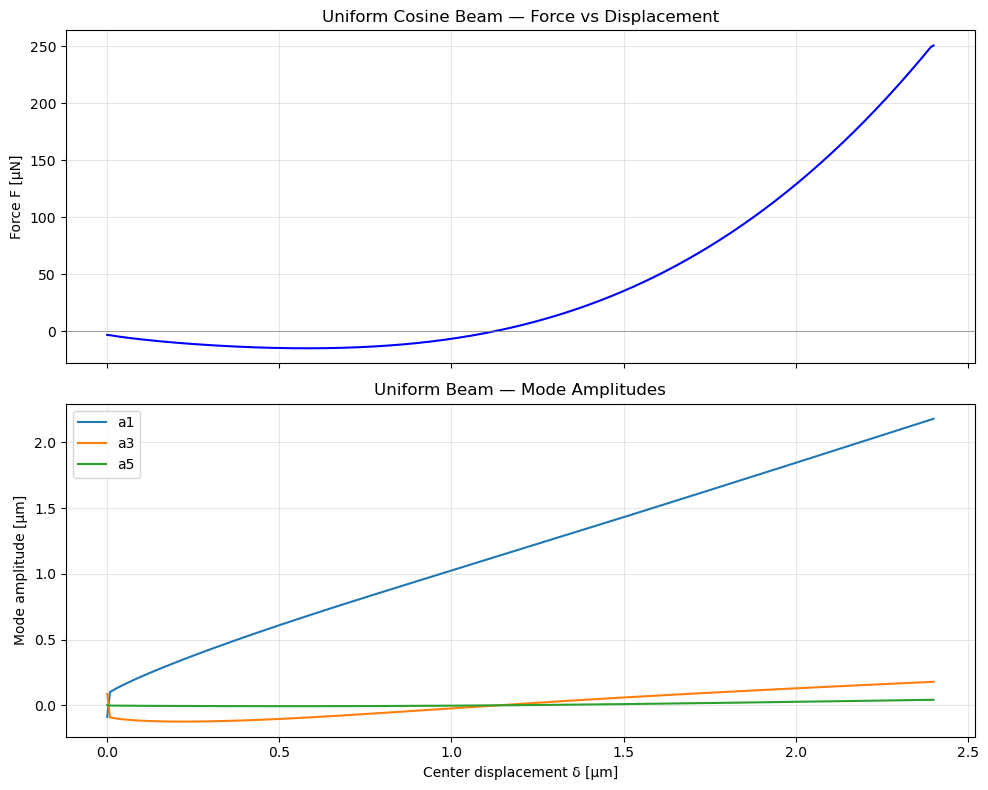

Uniform beam: F_push = 250.8685 µN, F_pop = -15.1773 µN
Push/Pop ratio = 0.060 (literature: ~0.76)


In [5]:
# Plot uniform beam results
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(delta_range, F_uniform, 'b-', linewidth=1.5)
axes[0].axhline(0, color='gray', linewidth=0.5)
axes[0].set_ylabel('Force F [µN]')
axes[0].set_title('Uniform Cosine Beam — Force vs Displacement')
axes[0].grid(True, alpha=0.3)

for j, n in enumerate(modes):
    axes[1].plot(delta_range, amps_uniform[:, j], label=f'a{n}')
axes[1].set_ylabel('Mode amplitude [µm]')
axes[1].set_xlabel('Center displacement δ [µm]')
axes[1].set_title('Uniform Beam — Mode Amplitudes')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# Identify critical forces
F_push_uniform = F_uniform.max()
F_pop_uniform = F_uniform.min()
ratio_uniform = abs(F_pop_uniform / F_push_uniform)
print(f"Uniform beam: F_push = {F_push_uniform:.4f} µN, F_pop = {F_pop_uniform:.4f} µN")
print(f"Push/Pop ratio = {ratio_uniform:.3f} (literature: ~0.76)")

## 4. CCS Beam (Actual Design)

For a CCS beam with variable width $w(x)$, the bending stiffness coefficients become:
$$\beta_n = E \int_0^L I(x) [\phi_n''(x)]^2 \, dx$$

where $I(x) = w(x) t^3 / 12$ varies with the stepped width profile.

The axial stiffness also uses the variable cross-section:
$$\bar{A} = \frac{1}{L} \int_0^L A(x) \, dx = \frac{t}{L} \int_0^L w(x) \, dx$$

In [6]:
# Compute CCS-specific bending coefficients via numerical integration
x_int = np.linspace(0, L, 2000)  # fine grid for integration
I_ccs = get_moment_of_inertia_profile(x_int)
w_ccs = get_beam_width_profile(x_int)
A_bar = t * trapezoid(w_ccs, x_int) / L  # effective average cross-section area

beta_ccs = {}
for n in modes:
    integrand = I_ccs * phi_xx(n, x_int, L)**2
    beta_ccs[n] = E * trapezoid(integrand, x_int)
    print(f"β_CCS({n}) = {beta_ccs[n]:.4f} µN·µm")

# Compare with uniform values
for n in modes:
    beta_uniform = 2.0 * n**4 * np.pi**4 * E * I_uniform / L**3
    print(f"β_uniform({n}) = {beta_uniform:.4f} µN·µm  "
          f"(ratio CCS/uniform = {beta_ccs[n]/beta_uniform:.3f})")

print(f"\nEffective avg cross-section area A_bar = {A_bar:.4f} µm²")

β_CCS(1) = 3.7576 µN·µm
β_CCS(3) = 336.4730 µN·µm
β_CCS(5) = 2556.5130 µN·µm
β_uniform(1) = 2.5367 µN·µm  (ratio CCS/uniform = 1.481)
β_uniform(3) = 205.4723 µN·µm  (ratio CCS/uniform = 1.638)
β_uniform(5) = 1585.4344 µN·µm  (ratio CCS/uniform = 1.612)

Effective avg cross-section area A_bar = 0.4031 µm²


In [7]:
# Also compute cross-coupling bending coefficients for completeness
# These arise because modes are NOT orthogonal w.r.t. variable-I inner product
# β_mn = E * ∫ I(x) φ_m''(x) φ_n''(x) dx
beta_cross = {}
for i, m in enumerate(modes):
    for j, n in enumerate(modes):
        integrand = I_ccs * phi_xx(m, x_int, L) * phi_xx(n, x_int, L)
        beta_cross[(m, n)] = E * trapezoid(integrand, x_int)

print("Bending stiffness matrix β_mn:")
for m in modes:
    row = [f"{beta_cross[(m,n)]:10.4f}" for n in modes]
    print(f"  n={m}: " + "  ".join(row))

# Check if cross-terms are significant
for m in modes:
    for n in modes:
        if m != n:
            ratio = abs(beta_cross[(m,n)]) / max(beta_cross[(m,m)], beta_cross[(n,n)])
            if ratio > 0.01:
                print(f"  Cross-coupling β({m},{n})/max(β_mm,β_nn) = {ratio:.4f}")

Bending stiffness matrix β_mn:
  n=1:     3.7576     -2.0957      4.0890
  n=3:    -2.0957    336.4730    -91.1114
  n=5:     4.0890    -91.1114   2556.5130
  Cross-coupling β(3,5)/max(β_mm,β_nn) = 0.0356
  Cross-coupling β(5,3)/max(β_mm,β_nn) = 0.0356


In [8]:
def energy_ccs(a_coeffs, delta, beta, A_bar, E, L, h):
    """Total energy for CCS beam with variable-width bending coefficients.
    
    Uses the full cross-coupling bending matrix.
    """
    # Bending energy: U_bend = 0.5 * Σ_m Σ_n a_m * β_mn * a_n
    U_bend = 0.0
    for i, m in enumerate(modes):
        for j, n in enumerate(modes):
            U_bend += a_coeffs[i] * beta[(m, n)] * a_coeffs[j]
    U_bend *= 0.5
    
    # Axial shortening (same formula, depends on mode shapes not I)
    S = 0.0
    for n_mode, a in zip(modes, a_coeffs):
        S += n_mode**2 * a**2
    S *= np.pi**2 / (2.0 * L)
    
    S0 = np.pi**2 * h**2 / (2.0 * L)
    
    # Axial energy with effective area
    U_axial = 0.5 * E * A_bar / L * (S - S0)**2
    
    return U_bend + U_axial


def minimize_energy_ccs(delta, beta, A_bar, E, L, h):
    """Minimize energy over free modes (a3, a5) with constraint a1+a3+a5=delta."""
    def objective(free_amps):
        a3, a5 = free_amps
        a1 = delta - a3 - a5
        return energy_ccs([a1, a3, a5], delta, beta, A_bar, E, L, h)
    
    res = minimize(objective, [0.0, 0.0], method='Nelder-Mead',
                   options={'xatol': 1e-12, 'fatol': 1e-15})
    a3, a5 = res.x
    a1 = delta - a3 - a5
    return res.fun, [a1, a3, a5]


# Sweep displacement
U_min_ccs = np.zeros(n_steps)
amps_ccs = np.zeros((n_steps, 3))

for i, d in enumerate(delta_range):
    U_min_ccs[i], amps_ccs[i] = minimize_energy_ccs(
        d, beta_cross, A_bar, E, L, h
    )

# Force
F_ccs = np.gradient(U_min_ccs, delta_range)

# Critical values
F_push_ccs = F_ccs.max()
F_pop_ccs = F_ccs.min()
ratio_ccs = abs(F_pop_ccs / F_push_ccs)
print(f"CCS beam: F_push = {F_push_ccs:.4f} µN, F_pop = {F_pop_ccs:.4f} µN")
print(f"Push/Pop ratio = {ratio_ccs:.3f} (target: ~0.87)")

CCS beam: F_push = 382.3679 µN, F_pop = -17.5443 µN
Push/Pop ratio = 0.046 (target: ~0.87)


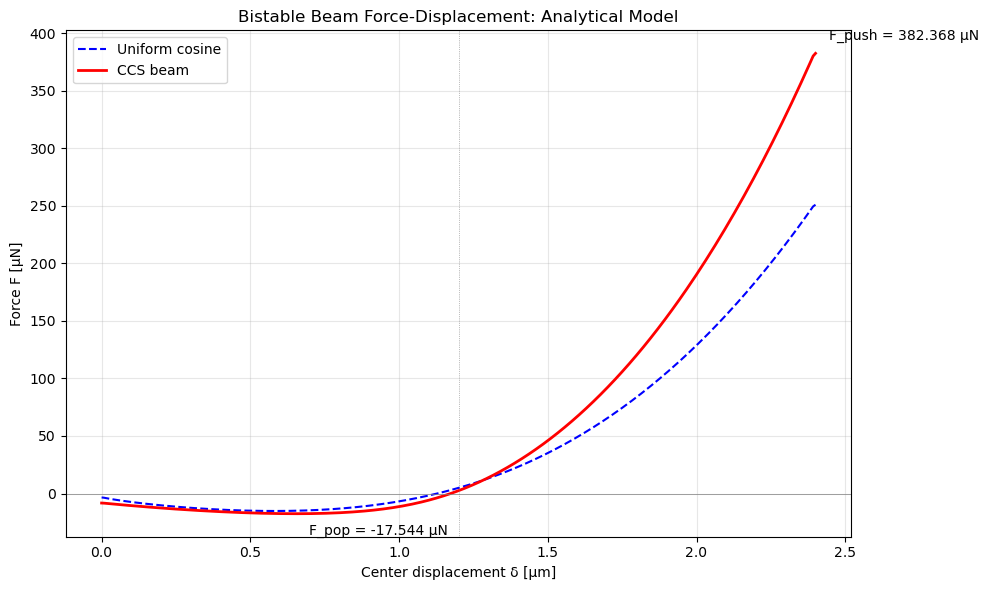

In [9]:
# Main force-displacement comparison plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(delta_range, F_uniform, 'b--', linewidth=1.5, label='Uniform cosine')
ax.plot(delta_range, F_ccs, 'r-', linewidth=2, label='CCS beam')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(h, color='gray', linewidth=0.5, linestyle=':')
ax.annotate(f'F_push = {F_push_ccs:.3f} µN', 
            xy=(delta_range[np.argmax(F_ccs)], F_push_ccs),
            xytext=(10, 10), textcoords='offset points')
ax.annotate(f'F_pop = {F_pop_ccs:.3f} µN',
            xy=(delta_range[np.argmin(F_ccs)], F_pop_ccs),
            xytext=(10, -15), textcoords='offset points')

ax.set_xlabel('Center displacement δ [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('Bistable Beam Force-Displacement: Analytical Model')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/analytical_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Energy Landscape

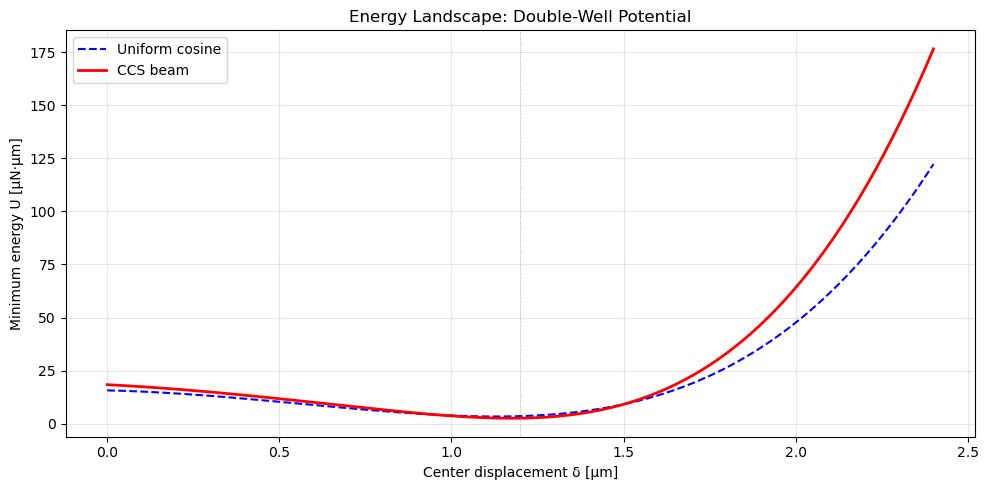

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(delta_range, U_min_uniform, 'b--', linewidth=1.5, label='Uniform cosine')
ax.plot(delta_range, U_min_ccs, 'r-', linewidth=2, label='CCS beam')
ax.axvline(h, color='gray', linewidth=0.5, linestyle=':')

ax.set_xlabel('Center displacement δ [µm]')
ax.set_ylabel('Minimum energy U [µN·µm]')
ax.set_title('Energy Landscape: Double-Well Potential')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/analytical_energy_landscape.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Mode Amplitudes

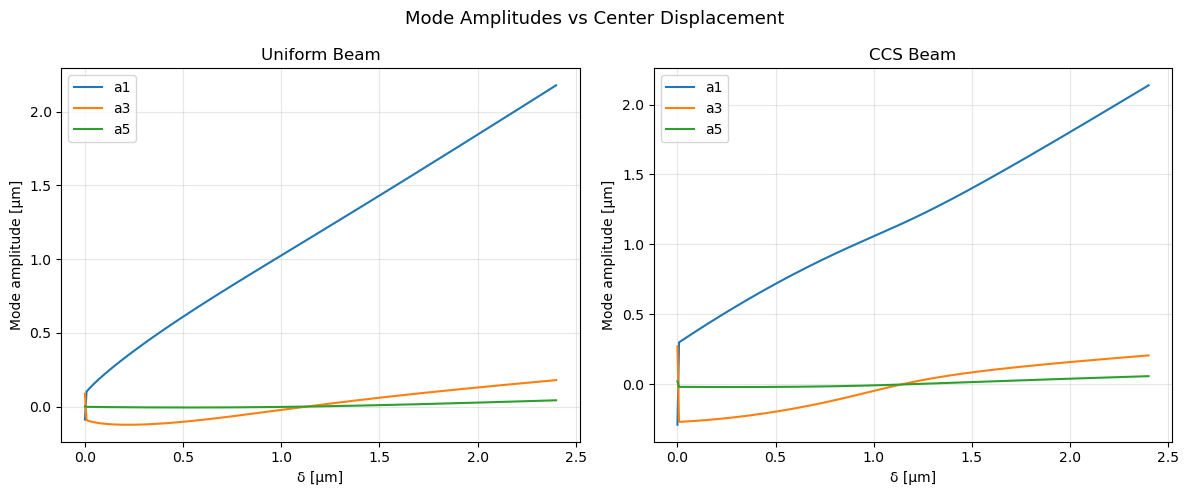

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for j, n in enumerate(modes):
    axes[0].plot(delta_range, amps_uniform[:, j], label=f'a{n}')
axes[0].set_xlabel('δ [µm]')
axes[0].set_ylabel('Mode amplitude [µm]')
axes[0].set_title('Uniform Beam')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for j, n in enumerate(modes):
    axes[1].plot(delta_range, amps_ccs[:, j], label=f'a{n}')
axes[1].set_xlabel('δ [µm]')
axes[1].set_ylabel('Mode amplitude [µm]')
axes[1].set_title('CCS Beam')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.suptitle('Mode Amplitudes vs Center Displacement', fontsize=13)
fig.tight_layout()
fig.savefig('plots/analytical_mode_amplitudes.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Deformed Shapes at Key Displacements

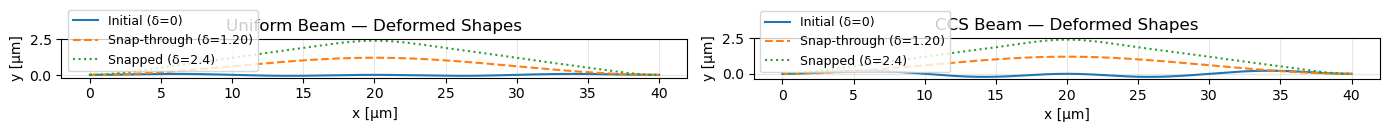

In [12]:
def beam_shape(x, a_coeffs, L):
    """Compute beam deflection w(x) from mode amplitudes."""
    w = np.zeros_like(x)
    for n, a in zip(modes, a_coeffs):
        w += a * phi(n, x, L)
    return w

x_plot = np.linspace(0, L, 500)

# Find snap-through point (where F crosses zero going negative)
idx_push = np.argmax(F_ccs)
# Find zero crossing after peak
zero_crossings = np.where(np.diff(np.sign(F_ccs[idx_push:])))[0]
if len(zero_crossings) > 0:
    idx_snap = idx_push + zero_crossings[0]
else:
    idx_snap = n_steps // 2

key_indices = {
    'Initial (δ=0)': 0,
    f'Snap-through (δ={delta_range[idx_snap]:.2f})': idx_snap,
    f'Snapped (δ={2*h:.1f})': -1,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for (label, idx), ls in zip(key_indices.items(), ['-', '--', ':']):
    y_uni = beam_shape(x_plot, amps_uniform[idx], L)
    y_ccs = beam_shape(x_plot, amps_ccs[idx], L)
    axes[0].plot(x_plot, y_uni, ls, linewidth=1.5, label=label)
    axes[1].plot(x_plot, y_ccs, ls, linewidth=1.5, label=label)

for ax, title in zip(axes, ['Uniform Beam', 'CCS Beam']):
    ax.set_xlabel('x [µm]')
    ax.set_ylabel('y [µm]')
    ax.set_title(f'{title} — Deformed Shapes')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

fig.tight_layout()
fig.savefig('plots/analytical_deformed_shapes.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results

In [13]:
import csv

# Save force-displacement data
np.savetxt('results/analytical_force_displacement.csv',
           np.column_stack([delta_range, F_uniform, F_ccs]),
           delimiter=',',
           header='delta_um,F_uniform_uN,F_ccs_uN',
           comments='')

# Save critical values
# Find snap-through displacements
delta_snap_uniform = delta_range[idx_push]  # approximate
delta_snap_ccs = delta_range[idx_push]

with open('results/analytical_critical_values.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['method', 'F_push_uN', 'F_pop_uN', 'push_pop_ratio',
                     'delta_snap_um', 'total_travel_um'])
    writer.writerow(['uniform_cosine', f'{F_push_uniform:.6f}',
                     f'{F_pop_uniform:.6f}', f'{ratio_uniform:.4f}',
                     f'{delta_snap_uniform:.4f}', f'{2*h:.4f}'])
    writer.writerow(['ccs_beam', f'{F_push_ccs:.6f}',
                     f'{F_pop_ccs:.6f}', f'{ratio_ccs:.4f}',
                     f'{delta_snap_ccs:.4f}', f'{2*h:.4f}'])

print("Saved: results/analytical_force_displacement.csv")
print("Saved: results/analytical_critical_values.csv")
print(f"\nSummary:")
print(f"{'':15s} {'F_push':>10s} {'F_pop':>10s} {'Ratio':>8s}")
print(f"{'Uniform':15s} {F_push_uniform:10.4f} {F_pop_uniform:10.4f} {ratio_uniform:8.3f}")
print(f"{'CCS':15s} {F_push_ccs:10.4f} {F_pop_ccs:10.4f} {ratio_ccs:8.3f}")

Saved: results/analytical_force_displacement.csv
Saved: results/analytical_critical_values.csv

Summary:
                    F_push      F_pop    Ratio
Uniform           250.8685   -15.1773    0.060
CCS               382.3679   -17.5443    0.046
